# Point a

We couldn't find the exact data asked, so we imported the best fitting data from FRED.

In [70]:
import requests
from key import fred_key
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


base_url = "https://api.stlouisfed.org/fred/"
obs_endpoint = "series/observations"

start_date = "1950-01-01"
end_date = "2023-12-31"


def create_series_dict(name, series_id):
    return {
        'name': name,
        'series_id': series_id,
        'api_key': fred_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date,
        'frequency': 'a',
        'units': 'lin'
    }

series_list = [
    ('GDP', 'GDPC1'),
    ('CND', 'PCEND'),
    ('CD', 'PCEDG'),
    ('H', 'HOANBS'),
    ('L', 'PAYEMS'),
    ('AveW', 'AHETPI')
]

request_parameters = [create_series_dict(name, series_id) for name, series_id in series_list]



In [96]:
def fetch_data(parameter):
    response = requests.get(base_url + obs_endpoint, params=parameter)
    if response.status_code == 200:
        res_data = response.json()
        obs_data = pd.DataFrame(res_data['observations'])
        obs_data['date'] = pd.to_datetime(obs_data['date'])
        obs_data.set_index('date', inplace=True)
        obs_data = obs_data.drop(['realtime_start', 'realtime_end'], axis=1)

        # Convert 'value' to numeric, coercing errors to NaN
        obs_data['value'] = pd.to_numeric(obs_data['value'], errors='coerce')

        obs_data.rename(columns={'value': parameter['name']}, inplace=True)
        return obs_data
    else:
        print('Failed to retrieve data. Status code:', response.status_code)
        return pd.DataFrame()  # Return an empty DataFrame on failure
    
    
dataframe = pd.DataFrame()
# concatenate the data
for parameter in request_parameters:
    df = fetch_data(parameter)
    if dataframe.empty:
        dataframe = df
    else:
        dataframe = pd.concat([dataframe, df], axis=1)

In [95]:
# adjust the dataset

# add productivity
dataframe['GDP/L'] = (dataframe['GDP']/dataframe['L'])  # annual average income
dataframe['AveH'] = dataframe['H']/dataframe['L']*1000
dataset1 = dataframe.dropna()
# data from 1964 to 2022



## Replicate Table 1

In [73]:
sd = dataset1.std()/dataset1.mean()

lags = range(-4, 5)

# initialize a DataFrame to store cross-correlation values
cross_corr_df = pd.DataFrame(index=dataset1.columns, columns=lags)

# calculate cross-correlation for each variable and each lag
for col in dataset1.columns:
    for lag in lags:
        cross_corr_df.at[col, lag] = dataset1['GDP'].corr(dataset1[col].shift(-lag))



cross_corr_df['SD%'] = sd
table1 = cross_corr_df
table1



,-4,-3,-2,-1,0,1,2,3,4,SD%
GDP,0.996157,0.996902,0.998006,0.999012,1.0,0.999012,0.998006,0.996902,0.996157,0.456230
CND,0.989164,0.990058,0.989764,0.987779,0.986553,0.986209,0.98596,0.98637,0.988491,0.750827
CD,0.991568,0.993298,0.989355,0.985254,0.981415,0.978577,0.976664,0.974612,0.974694,0.781369
H,0.956995,0.951185,0.950265,0.951792,0.953955,0.948412,0.940684,0.933495,0.926917,0.206383
L,0.975264,0.971531,0.969728,0.970067,0.971627,0.9699,0.966303,0.962447,0.958619,0.255275
AveW,0.995252,0.995148,0.994857,0.994162,0.993219,0.993012,0.992738,0.992388,0.993354,0.583056
GDP/L,0.988295,0.990481,0.99224,0.99373,0.99417,0.994016,0.995472,0.996699,0.997268,0.226308
AveH,-0.881602,-0.883717,-0.879279,-0.875903,-0.876424,-0.889888,-0.908078,-0.924259,-0.930663,0.065301


There is a very high correlation with the GDP. This could mean that the Economist ran some de-trending techniques that are not specified in the Problem Set.  

In [74]:
# import data for the second table

series_list2 = [
    ('Y', 'A939RC0Q052SBEA'),
    ('C', 'A794RC0Q052SBEA'),
    ('I', 'RGDPLPUSA625NUPN'),
    ('w', 'LES1252881600Q'),
    ('r', 'FEDFUNDS'),
    ('A', 'RTFPNAUSA632NRUG')
]

request_parameters2 = [create_series_dict(name, series_id) for name, series_id in series_list2]


dataframe2 = pd.DataFrame()
# concatenate the data
for parameter in request_parameters2:
    df = fetch_data(parameter)
    if dataframe2.empty:
        dataframe2 = df
    else:
        dataframe2 = pd.concat([dataframe2, df], axis=1)

dataframe2['N'] = dataset1['AveH']
dataframe2['Y/N'] = dataframe2['Y']/dataframe2['N']

dataset2 = dataframe2.dropna()
# data from 1982 to 2007
dataset3 = dataset2.apply(lambda col: np.log(col) if col.name != 'r' else col)



dataset2_c  = pd.DataFrame()
for column in dataset3.columns:
    cycle, _ = sm.tsa.filters.hpfilter(dataset3[column], lamb=1600)
    dataset2_c[column] = cycle





## Replicate Table 2 

In [93]:
sd2 = dataset2_c.std()
sd_r = sd2/dataset2_c['Y'].std()
p = dataset2_c.apply(lambda series: series.autocorr(lag = 1)) # first order autocorrection (how much the t value is influenced by the t-1 value )
corr_Y = dataset2_c.corr()['Y']

table2 = pd.DataFrame(index=dataset2_c.columns)
table2['SD'] = sd2
table2['SD%'] = sd_r
table2['p'] = p
table2['corr_Y'] = corr_Y
table2

,SD,SD%,p,corr_Y
Y,0.034149,1.000000,0.764941,1.000000
C,0.035240,1.031949,0.827277,0.978454
I,0.031741,0.929493,0.717496,0.518569
w,0.019735,0.577904,0.712322,-0.155843
r,1.802591,52.786217,0.516510,0.142384
A,0.011091,0.324782,0.558993,0.154666
N,0.012061,0.353200,0.643295,0.558470
Y/N,0.029182,0.854545,0.789934,0.939387


# Point B

## Is Consumption (C) Smoother than Output (Y)?

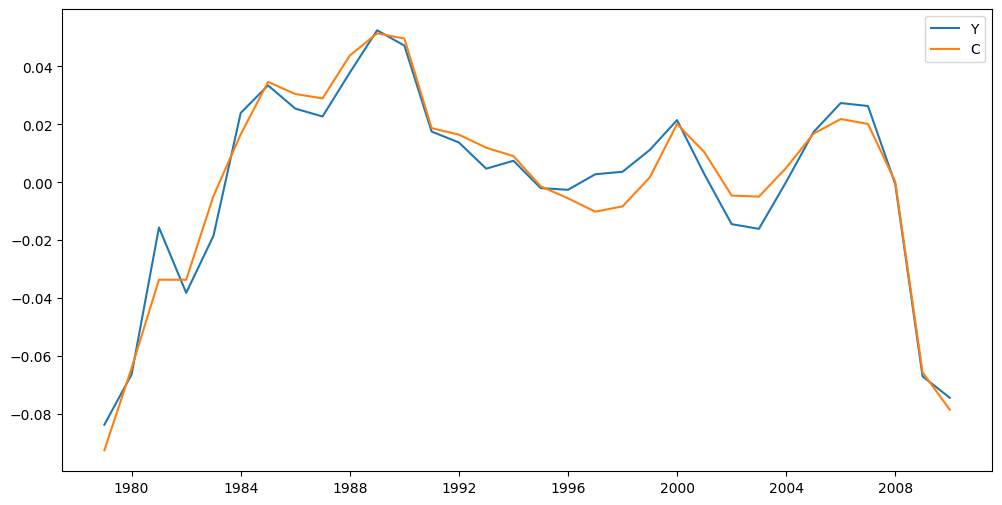

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(dataset2_c.index, dataset2_c['Y'], label='Y')
plt.plot(dataset2_c.index, dataset2_c['C'], label='C')
plt.legend()

We can't really see.

In [77]:
diff_Y = dataset2_c['Y'].diff()
diff_C = dataset2_c['C'].diff()

# calculate the standard deviation of the first difference
sc_Y = diff_Y.std()
sc_C = diff_C.std()

# lower standard deviation means smoother series
print('Smoothness coefficient for Y:', sc_Y)
print('Smoothness coefficient for C:', sc_C)

Smoothness coefficient for Y: 0.021577125401106397
Smoothness coefficient for C: 0.018898095189354272


We have computed the smoothness of Y and C with the standard deviation of the differences between different years. 
Consumption is smoother than the output because the standard deviation of the differences is lower.

## Is Volatility in GDP similar in magnitude to volatility in total hours?

In [78]:
sd_GDP = dataset1['GDP'].std()/dataset1['GDP'].mean()
sd_H = dataset1['H'].std()/dataset1['H'].mean()
print(' GDP SD:', sd_GDP)
print('Total Hours SD:', sd_H)

 GDP SD: 0.45622985774816327
Total Hours SD: 0.20638266428542026


They are not similar in magnitude. The relative standard deviation of GDP is more than double than the standard deviation of total hours.

## Is volatility in employment greater than volatility in average hours?

In [79]:
sd_L = dataset1['L'].std()/dataset1['L'].mean()
sd_AveH = dataset1['AveH'].std()/dataset1['AveH'].mean()
print('Employment SD:', sd_L)
print('Average Hours SD:', sd_AveH)

Employment SD: 0.25527535497308446
Average Hours SD: 0.0653007267399741


Yes, the volatility in employment is much greater than the volatility in average hours.

## Is productivity slightly procyclical?

In [80]:
c_YA= dataset2_c['Y'].corr(dataset2_c['A'])
print('Correlation between Y and A:', c_YA)

Correlation between Y and A: 0.15466648915714679


Yes, productivity is slightly procyclical because the correlation is slightly positive.

## Are wages less variable than productivity?

In [94]:
sd_W = dataset2['w'].std()/dataset2['w'].mean()
sd_A = dataset2['A'].std()/dataset2['A'].mean()
print('Wages SD:', sd_W)
print('Productivity SD:', sd_A)


Wages SD: 0.03201728814382639
Productivity SD: 0.07198321702621593


Yes, wages are less variable than productivity.

## Is there correlation between wages and output?

In [82]:
c_Yw = dataset2['Y'].corr(dataset2['w'])
print('Correlation between Y and w:', c_Yw)

Correlation between Y and w: 0.7189419826488415


Yes, there is a strong positive correlation between wages and output.

# Point C

## Is consumption of non-durables less volatile than output?

In [83]:
sd_CND = dataset1['CND'].std()/dataset1['CND'].mean()
sd_Y = dataset1['GDP'].std()/dataset1['GDP'].mean()
print('CND SD:', sd_CND)
print('Output SD:', sd_Y)

CND SD: 0.7508268658127834
Output SD: 0.45622985774816327


No, consumption of non-durables is more volatile than output.

## Is durables consumption more volatile than output?

In [84]:
sd_CD = dataset1['CD'].std()/dataset1['CD'].mean()
print('CD SD:', sd_CD)

CD SD: 0.781368866709871


Yes, durables consumption is more volatile than output.

## Is investment three times more volatile than output?

In [85]:
sd_I = dataset2['I'].std()/dataset2['I'].mean()
sd_Y = dataset2['Y'].std()/dataset2['Y'].mean()
print('Investment SD:', sd_I)
print('Output SD:', sd_Y)


Investment SD: 0.18126323777437398
Output SD: 0.39756127545406267


No, investment is not three times more volatile than output.

## Is Government Spending less volatile than output?

We don't have data for government spending and trade balance in the dataset. We will fetch the data from FRED.

In [86]:
public_expenditure = [('G', 'GCEC1')] # real government consumption expenditures and gross investment
g = [create_series_dict(name, series_id) for name, series_id in public_expenditure]
g_dataframe = fetch_data(g[0])


sd_G = g_dataframe['G'].std()/g_dataframe['G'].mean()
sd_Y = dataset1['GDP'].std()/dataset1['GDP'].mean()
print('Government Spending SD:', sd_G)
print('Output SD:', sd_Y)




Government Spending SD: 0.3883564096965604
Output SD: 0.45622985774816327


Yes, Government Spending is less volatile than output.

## Is total hours worked about as volatile as output?

In [87]:
sd_H = dataset1['H'].std()/dataset1['H'].mean()
sd_Y = dataset1['GDP'].std()/dataset1['GDP'].mean()
print('Total Hours SD:', sd_H)
print('Output SD:', sd_Y)

Total Hours SD: 0.20638266428542026
Output SD: 0.45622985774816327


No, output is more than two times more volatile than total hours worked.

## Is capital much less volatile than output?


We couldn't find data about real total capital. We've then fetched nominal data from FRED both for capital and GDP. Comparing Real GDP with Nominal Capital wouldn't have sense, because the second one volability is influenced by inflation. 

In [88]:
capital = [('K', 'BOGZ1FA895050005Q')] # total capital expenditure
k = [create_series_dict(name, series_id) for name, series_id in capital]
k_dataframe = fetch_data(k[0])

nominal_gdp = [('NGDP', 'GDP')] # total capital expenditure
ngdp = [create_series_dict(name, series_id) for name, series_id in nominal_gdp]
ngdp_dataframe = fetch_data(ngdp[0])

sd_K = k_dataframe['K'].std()/k_dataframe['K'].mean()
sd_Y = ngdp_dataframe['NGDP'].std()/ngdp_dataframe['NGDP'].mean()
print('Capital SD:', sd_K)
print('Output SD:', sd_Y)

Capital SD: 0.9768640775216679
Output SD: 1.0005333399020928


Yes, capital is less volatile than output, we wouldn't say "much less".

## Is Employment as volatile as output? Are hours per worker much less volatile than output?

In [89]:
sd_L = dataset1['L'].std()/dataset1['L'].mean()
sd_Y = dataset1['GDP'].std()/dataset1['GDP'].mean()
print('Employment SD:', sd_L)
print('Output SD:', sd_Y)

Employment SD: 0.25527535497308446
Output SD: 0.45622985774816327


No, employment is much less volatile than output. 

In [90]:
sd_N = dataset2['N'].std()/dataset2['N'].mean()
sd_Y = dataset2['Y'].std()/dataset2['Y'].mean()
print('Hours per Worker SD:', sd_N)
print('Output SD:', sd_Y)

Hours per Worker SD: 0.033349727279074724
Output SD: 0.39756127545406267


Yes, hours per worker is much less volatile than output.

## Is productivity less volatile than output?

In [91]:
sd_A = dataset2['A'].std()/dataset2['A'].mean()
sd_Y = dataset2['Y'].std()/dataset2['Y'].mean()
print('Productivity SD:', sd_A)
print('Output SD:', sd_Y)

Productivity SD: 0.07198321702621593
Output SD: 0.39756127545406267


Yes, productivity is less volatile than output.

## Is the real wage much less volatile than output?

In [92]:
sd_w = dataset2['w'].std()/dataset2['w'].mean()
sd_Y = dataset2['Y'].std()/dataset2['Y'].mean()
print('Real Wage SD:', sd_w)
print('Output SD:', sd_Y)

Real Wage SD: 0.03201728814382639
Output SD: 0.39756127545406267


Yes, the real wage is less volatile than output.